# Packages and lib imports

In [58]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ConfigManager
import torchviz

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [60]:
model_name = 'unet_v3_channel2_noiseless_c_big_ds_mu057_v1'
trained_model_path = '/data/yarcoh/thesis_data/data/test_models/'+model_name
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/c/noiseless_big/30000samples_20mu'
ds_subdir = 'mu=0.57'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [61]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [62]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.05,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.5736842105263158,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': False,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'c',
 'N_sc': 256,
 'T_guardband': 4750.0880922277665,
 'N_sc_raw': 237.50440461138834,
 'L': 960,
 'T0': 5120.0,
 'Tb': 10240.0,
 'Tn': 1358.1221810508403,
 'Zn': 87833.13612677579,
 'Pn': 8.964743939765935e-06,
 'Ns': 4096,
 'Nnft': 16384,
 'Tnft': 68266.66666666667,
 'dt': 4.166666666666667,
 'Nb': 2458,
 'T1': -25.132741228718345,
 'T2': 25.12967326714258,
 'XI': array([-511.9375,  512.    ])}

In [63]:
trainer.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 256]             224
              Tanh-2              [-1, 32, 256]               0
         MaxPool1d-3              [-1, 32, 128]               0
            Conv1d-4              [-1, 64, 128]           6,208
              Tanh-5              [-1, 64, 128]               0
         MaxPool1d-6               [-1, 64, 64]               0
            Conv1d-7              [-1, 128, 64]          24,704
              Tanh-8              [-1, 128, 64]               0
   ConvTranspose1d-9               [-1, 64, 64]          24,640
             Tanh-10               [-1, 64, 64]               0
  ConvTranspose1d-11              [-1, 32, 128]           4,128
             Tanh-12              [-1, 32, 128]               0
  ConvTranspose1d-13               [-1, 2, 256]             130
Total params: 60,034
Trainable params: 

saved model architecture to /data/yarcoh/thesis_data/data/test_models/unet_v3_channel2_noiseless_c_big_ds_mu057_v1/_analyze/architecture.png


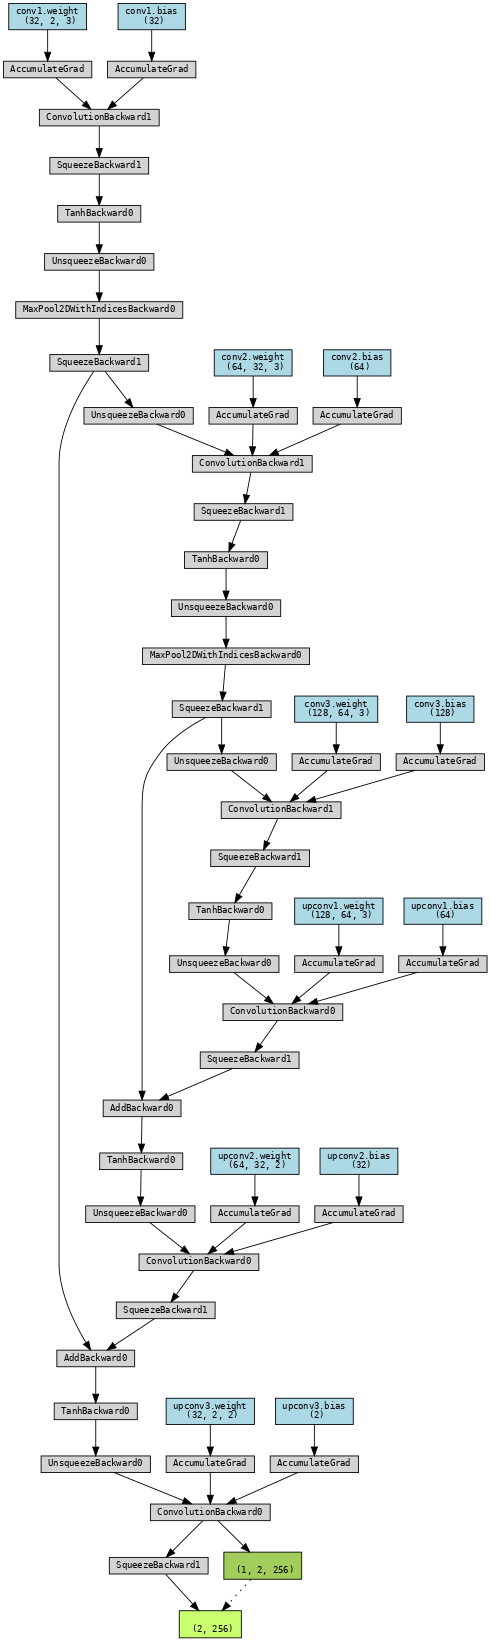

In [64]:
from IPython.display import Image
path = f'{trained_model_path}/_analyze/architecture'
trainer.plot_architecture(path)

# Replace 'image_path' with the path to your image file
Image(filename=path+'.png')


In [53]:
# for broken models with old config
inp = input('Do you want to refresh config? (y/n) ')
if inp == 'y':
    trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)
    trainer.save(trained_model_path)
else:
        print('config not refreshed')

config not refreshed


In [65]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [67]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [ ]:
print(len(trainer.val_dataset))

In [ ]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

In [ ]:
print(ma.cs_in.channel_config.io_type)

In [ ]:
# ma.plot_single_item(1)
N = ma.cs_in.channel_config.Ns
N = ma.cs_in.channel_config.N_sc
ma.cs_in.channel_config.io_type
ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

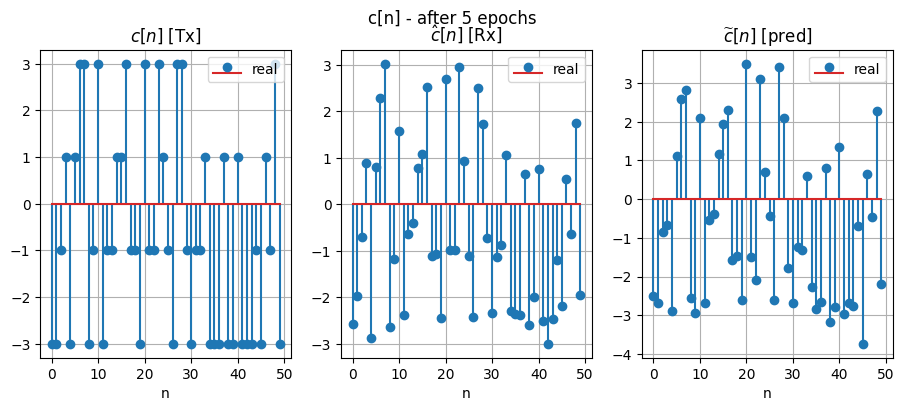

In [68]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

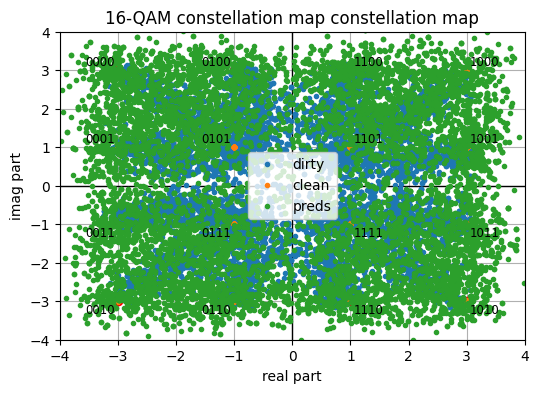

In [69]:
ma.plot_constelation(range(0,40))

In [ ]:
x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

In [ ]:
# ma.upload_single_item_plots_to_wandb(1)

In [70]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.1184462890625


  0%|          | 0/1000 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.0796943359375
the ber improvement is 32.72%


In [ ]:
ma.upload_bers_to_wandb()

# test all BERs

In [ ]:
# add powers

from apps.deep.power_adder import PowerAdder


power_adder = PowerAdder(is_overright=True, verbose_level=2)
power_adder.calculate_and_add_powers(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.100 | org_ber=0.00e+00 | model_ber=4.24e-02 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.150 | org_ber=0.00e+00 | model_ber=4.37e-02 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.190 | org_ber=0.00e+00 | model_ber=4.10e-02 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.240 | org_ber=0.00e+00 | model_ber=4.13e-02 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.290 | org_ber=0.00e+00 | model_ber=4.46e-02 |  ber_improve=000%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.340 | org_ber=4.23e-05 | model_ber=4.64e-02 |  ber_improve=-109492%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.380 | org_ber=1.80e-03 | model_ber=4.24e-02 |  ber_improve=-2254%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.430 | org_ber=9.26e-03 | model_ber=4.29e-02 |  ber_improve=-363%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.480 | org_ber=3.28e-02 | model_ber=4.93e-02 |  ber_improve=-50%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.530 | org_ber=7.23e-02 | model_ber=6.02e-02 |  ber_improve=017%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.570 | org_ber=1.16e-01 | model_ber=5.36e-02 |  ber_improve=054%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.620 | org_ber=1.67e-01 | model_ber=1.15e-01 |  ber_improve=031%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.670 | org_ber=2.12e-01 | model_ber=1.53e-01 |  ber_improve=028%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.720 | org_ber=2.45e-01 | model_ber=1.89e-01 |  ber_improve=023%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.760 | org_ber=2.77e-01 | model_ber=2.27e-01 |  ber_improve=018%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.810 | org_ber=3.03e-01 | model_ber=2.64e-01 |  ber_improve=013%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.860 | org_ber=3.20e-01 | model_ber=2.88e-01 |  ber_improve=010%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.910 | org_ber=3.39e-01 | model_ber=3.09e-01 |  ber_improve=009%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=0.950 | org_ber=3.53e-01 | model_ber=3.32e-01 |  ber_improve=006%


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

mu=1.000 | org_ber=3.61e-01 | model_ber=3.42e-01 |  ber_improve=005%


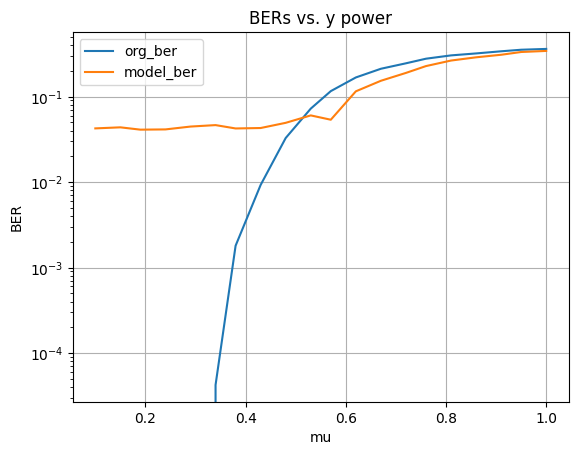

In [71]:
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.01, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)
                    

In [ ]:
# upload to wandb
ma.upload_all_bers_to_wandb(base_path=main_ds_path,
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.01, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)

# THE END

In [ ]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [ ]:
# analyze on the whole dataset

# attach new dataset to trainer


In [ ]:
trainer.params

In [ ]:
ma = ModelAnalyzer(trainer)

In [ ]:
ma.plot_single_item(i=0)

In [ ]:
ma.plot_bers(_tqdm=tqdm)